## Polynomial regression

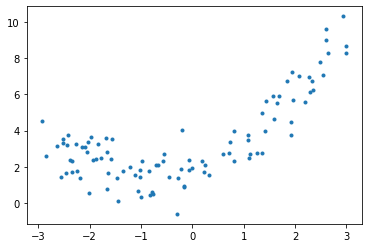

In [67]:
import matplotlib.pyplot as plt
import numpy as np

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
plt.scatter(X, y, marker = ".")
plt.show()

In [68]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-1.93639148]), array([-1.93639148,  3.74961195]))

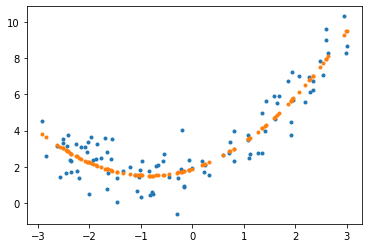

In [69]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_
predictions = lin_reg.predict(X_poly)
plt.plot(X, y, ".")
plt.plot(X, predictions, '.')
plt.show()

### Learning curve
* plots of the model's performance on the training set and the validation set.
* To generate the plots, train the model several times on different sized subsets of the training set.

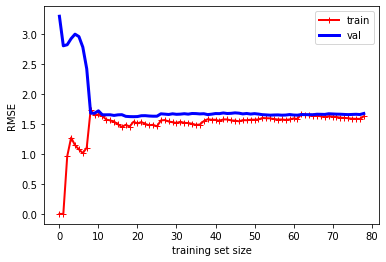

In [70]:
## Learning curve of a linear model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label = "val")
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.xlabel("training set size")
plt.ylabel("RMSE")
plt.legend(loc="upper right")
# Shows that after some points, it becomes impossible for the model to fit the training data better
# because the data is noisy and it is not linear at all.
# The conclusion here is that the linear model cannot do a good job modeling the data, so the error
# ends up at a plateau(/plaˈtō/), very close to the other curve.

(0, 3)

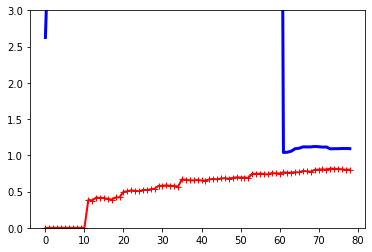

In [71]:
# Learning curves of a 10th-degree polynomial model
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias = False)),
    ("lin_reg", LinearRegression()),
])
plot_learning_curves(polynomial_regression, X, y)
plt.ylim(0, 3)
# Shows that the error on the training data is much lower than with the LR model
# The gap between the curves is present meaning that the model performs better on the training set
# indicating overfitting

## Ridge regression (L2)
* A regularization term alpha/2 * summation{i= 1 to n}(theta_i^2) is added to the cost function.  
(alpha= hyperparameter to control how much the model should be regularized.)
* This forces the learning algorithm to keep the weights as small as possible.
* The regularization term should only be added during training. Once the model is trained,  
you want to use the unregularized performance measure to evaluate the model's performance.

In [72]:
# Demonstration:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver = "cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.93011686]])

In [73]:
# We can use l2 with SGD:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.9292185])

## Lasso regression (L1)
* 'Least Absolute Shrinkage and Selection Operator' regression
* It also adds a regularization term to the cost function but it uses the l1 norm of the weight vecor (alpha * summation{i=1 to n}(abs(theta_i)))
* It tends to eliminate the weights of the least important features by setting them to zero,  
meaning it automatically performs feature selection and outputs a sparse model. (see pg 138, 139 for details)

In [74]:
# Demonstration:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])
# can also use penalty = l1 option in the SGDRegressor

array([4.87894192])

## Elastic net
* Is a middle ground between ridge and lasso.
* The regularization term is a simple mix of both ridge and lasso's terms and can control the mix ratio r.  
r * alpha * summation{i=1 to n}(abs(theta_i)) + (1-r)/2 * alpha * summation{i=1 to n} * theta_i^2
* When r = 0, elastic net = ridge, when r = 1, elastic net = lasso  

In [75]:
# Demonstration:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5) # l1 ratio = r
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.88180385])

## So how to choose what to use?
* Should have at least a little bit of regularization.
* Ridge = a good default
* Lasso = good if you suspect that only a few features are useful
* Elastic net = preferred over lasso in general b/c lasso may behave erratically when # features > # training instances,  
or when several features are strongly correlated.

## Early stopping
* The idea is to stop GD from training further when the validation error reaches a minimum.
* Geoffrey Hinton called it a 'beautiful free lunch'
* Easy to spot a minimum in batch GD but may not be for SGD and mini-batch GD b/c their curves are not so smooth.
* One solution is to stop only after the validation error has been above the minimum for some time, then roll back  
the model parameters to the point where the validation error was at a minimum.

In [76]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# prepare the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias = False)),
    ("std_scaler", StandardScaler())
])

In [81]:
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
            penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel()) # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
# when warm_start=true, when the fit() method is called it continues training where it left off,
# instead of restarting from scratch.
best_epoch, val_error.round(2)

(588, 0.94)